
--- Dataset Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 1 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   fare_amount  100000 non-null  float64
dtypes: float64(1)
memory usage: 781.4 KB
None
         fare_amount
count  100000.000000
mean       11.354652
std         9.716777
min       -44.900000
25%         6.000000
50%         8.500000
75%        12.500000
max       200.000000

--- Isolation Forest ---

--- One-Class SVM ---

--- Isolation Forest ---
Accuracy: 0.9826
Precision: 1.0000
Recall: 0.3630
F1 Score: 0.5327
Confusion Matrix:
[[97273     0]
 [ 1737   990]]

--- One-Class SVM ---
Accuracy: 0.9702
Precision: 0.3852
Recall: 0.1525
F1 Score: 0.2185
Confusion Matrix:
[[96609   664]
 [ 2311   416]]


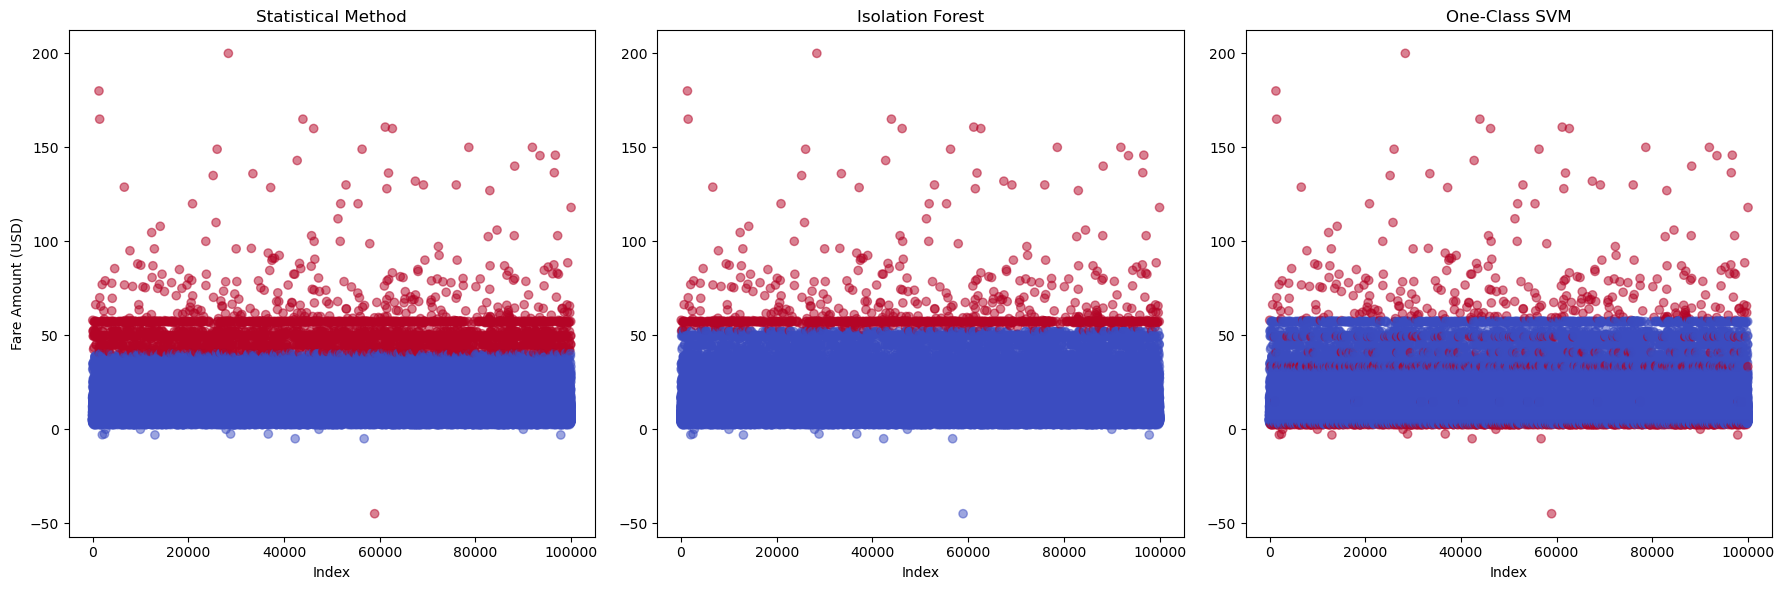


All detected anomalies saved to 'anomalies_comparison.csv'


In [5]:
# -------------------------------------
# 📥 Import Libraries and Load Data
# -------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Load Dataset (Load 100k rows for efficiency)
data = pd.read_csv('train.csv', usecols=['fare_amount'], nrows=100000)

# Display basic info
print("\n--- Dataset Info ---")
print(data.info())
print(data.describe())

# -------------------------------------
# 🔍 Basic Statistics (from Day 1)
# -------------------------------------
mean_fare = data['fare_amount'].mean()
std_fare = data['fare_amount'].std()
median_fare = data['fare_amount'].median()
q1 = data['fare_amount'].quantile(0.25)
q3 = data['fare_amount'].quantile(0.75)
iqr = q3 - q1

# -------------------------------------
# 📊 Statistical Anomaly Detection (Day 1)
# -------------------------------------
# Define thresholds
std_threshold = 3
lower_std, upper_std = mean_fare - std_threshold * std_fare, mean_fare + std_threshold * std_fare

# Detect anomalies
data['stat_anomaly'] = (data['fare_amount'] < lower_std) | (data['fare_amount'] > upper_std)

# -------------------------------------
# 🚀 Isolation Forest Model
# -------------------------------------
print("\n--- Isolation Forest ---")
iso_forest = IsolationForest(n_estimators=100, contamination=0.01, random_state=42)
data['iso_forest_anomaly'] = iso_forest.fit_predict(data[['fare_amount']])

# Convert labels to match statistical labels (1=normal, -1=anomaly)
data['iso_forest_anomaly'] = data['iso_forest_anomaly'].apply(lambda x: 1 if x == -1 else 0)

# -------------------------------------
# 🚀 One-Class SVM Model
# -------------------------------------
print("\n--- One-Class SVM ---")
oc_svm = OneClassSVM(nu=0.01, kernel='rbf', gamma='scale')
data['svm_anomaly'] = oc_svm.fit_predict(data[['fare_amount']])

# Convert labels to match statistical labels (1=normal, -1=anomaly)
data['svm_anomaly'] = data['svm_anomaly'].apply(lambda x: 1 if x == -1 else 0)

# -------------------------------------
# ✅ Performance Comparison
# -------------------------------------
def calculate_metrics(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f"\n--- {model_name} ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("Confusion Matrix:")
    print(cm)

# Use statistical anomalies as ground truth for comparison
y_true = data['stat_anomaly'].astype(int)

# Calculate metrics
calculate_metrics(y_true, data['iso_forest_anomaly'], "Isolation Forest")
calculate_metrics(y_true, data['svm_anomaly'], "One-Class SVM")

# -------------------------------------
# 📊 Visualization: Anomaly Detection Comparison
# -------------------------------------
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Statistical Method
axs[0].scatter(data.index, data['fare_amount'], c=data['stat_anomaly'], cmap='coolwarm', alpha=0.5)
axs[0].set_title('Statistical Method')
axs[0].set_xlabel('Index')
axs[0].set_ylabel('Fare Amount (USD)')

# Isolation Forest
axs[1].scatter(data.index, data['fare_amount'], c=data['iso_forest_anomaly'], cmap='coolwarm', alpha=0.5)
axs[1].set_title('Isolation Forest')
axs[1].set_xlabel('Index')

# One-Class SVM
axs[2].scatter(data.index, data['fare_amount'], c=data['svm_anomaly'], cmap='coolwarm', alpha=0.5)
axs[2].set_title('One-Class SVM')
axs[2].set_xlabel('Index')

plt.tight_layout()
plt.show()

# -------------------------------------
# ✅ Save Results
# -------------------------------------
# Save all anomalies detected by Isolation Forest and One-Class SVM
anomalies_combined = data[data['iso_forest_anomaly'] == 1].copy()
anomalies_combined['Model'] = 'Isolation Forest'

anomalies_svm = data[data['svm_anomaly'] == 1].copy()
anomalies_svm['Model'] = 'One-Class SVM'

# Combine both models' anomalies
all_anomalies = pd.concat([anomalies_combined, anomalies_svm])

# Save to CSV
all_anomalies.to_csv("anomalies_comparison.csv", index=False)
print("\nAll detected anomalies saved to 'anomalies_comparison.csv'")